# Chapter 4. Transfer Learning and Other Tricks

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from PIL import Image, ImageFile
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

In [3]:
train_data_path = "data/train/"

transforms_ = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225] )
    ])

train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=transforms_, is_valid_file=check_image)

val_data_path = "data/val/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,
                                            transform=transforms_, is_valid_file=check_image)
test_data_path = "data/test/"
test_data = torchvision.datasets.ImageFolder(root=test_data_path,
                                             transform=transforms_, is_valid_file=check_image)

batch_size=64
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [5]:
transfer_model = models.resnet50(pretrained=True)

## Freezing parameters

Next, we need to freeze the layers. The way we do this is simple: we stop them from accumulating gradients by using requires_grad(). We need to do this for every parameter in the network, but helpfully, PyTorch provides a parameters() method that makes this rather easy:

You might not want to freeze the BatchNorm layers in a model, as they will be trained to approximate the mean and standard deviation of the dataset that the model was originally trained on, not the dataset that you want to fine-tune on. 

Some of the signal from your data may end up being lost as BatchNorm corrects your input. You can look at the model structure and freeze only layers that aren’t BatchNorm like this:

In [6]:
for name, param in transfer_model.named_parameters():
    if("bn" not in name):
        param.requires_grad = False

## Replacing the classifier

Then we need to replace the final classification block with a new one that we will train for detecting cats or fish. In this example, we replace it with a couple of Linear layers, a ReLU, and Dropout, but you could have extra CNN layers here too. 

Happily, the definition of PyTorch’s implementation of ResNet stores the final classifier block as an instance variable, fc, so all we need to do is replace that with our new structure (other models supplied with PyTorch use either fc or classifier, so you’ll probably want to check the definition in the source if you’re trying this with a different model type):

In [7]:
transfer_model.fc = nn.Sequential(nn.Linear(transfer_model.fc.in_features,500),
nn.ReLU(),                                 
nn.Dropout(), nn.Linear(500,2))

## Training Again

In [8]:
from tqdm import tqdm

def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in tqdm(range(epochs)):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [9]:
print(len(val_data_loader.dataset))

113


In [10]:
transfer_model.to(device)
optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)

In [11]:
train(transfer_model, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=5, 
      device=device)

 20%|██        | 1/5 [00:13<00:55, 13.79s/it]

Epoch: 0, Training Loss: 0.54, Validation Loss: 0.48, accuracy = 0.78


 40%|████      | 2/5 [00:20<00:34, 11.55s/it]

Epoch: 1, Training Loss: 0.19, Validation Loss: 0.19, accuracy = 0.93


 60%|██████    | 3/5 [00:26<00:19, 10.00s/it]

Epoch: 2, Training Loss: 0.08, Validation Loss: 0.17, accuracy = 0.95


 80%|████████  | 4/5 [00:32<00:08,  8.91s/it]

Epoch: 3, Training Loss: 0.05, Validation Loss: 0.14, accuracy = 0.95


100%|██████████| 5/5 [00:39<00:00,  7.85s/it]

Epoch: 4, Training Loss: 0.04, Validation Loss: 0.14, accuracy = 0.96


## Finding That Learning Rate

The learning rate for training neural networks is one of the most important hyperparameters you can alter, and then waved away what you should use for it, suggesting a rather small number and for you to experiment with different values. 

Well…the bad news is, that really is how a lot of people discover the optimum learning rate for their architectures, usually with a technique called grid search, exhaustively searching their way through a subset of learning rate values, comparing the results against a validation dataset. This is incredibly time-consuming, and although people do it, many others err on the side of the practioner’s lore. 

For example, a learning rate value that has empirically been observed to work with the Adam optimizer is 3e-4. This is known as Karpathy’s constant, after Andrej Karpathy (currently director of AI at Tesla) tweeted about it in 2016. 

Unfortunately, fewer people read his next tweet: “I just wanted to make sure that people understand that this is a joke.” The funny thing is that 3e-4 tends to be a value that can often provide good results, so it’s a joke with a hint of reality about it.

On the one hand, you have slow and cumbersome searching, and on the other, obscure and arcane knowledge gained from working on countless architectures until you get a feel for what a good learning rate would be—artisanal neural networks, even. Is there a better way than these two extremes?

Thankfully, the answer is yes, although you’ll be surprised by how many people don’t use this better method. A somewhat obscure paper by Leslie Smith, a research scientist at the US Naval Research Laboratory, contained an approach for finding an appropriate learning rate.1 But it wasn’t until Jeremy Howard brought the technique to the fore in his fast.ai course that it started to catch on in the deep learning community. 

The idea is quite simple: over the course of an epoch, start out with a small learning rate and increase to a higher learning rate over each mini-batch, resulting in a high rate at the end of the epoch. Calculate the loss for each rate and then, looking at a plot, pick the learning rate that gives the greatest decline.

In [12]:
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="cpu"):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Crash out if loss explodes

        if batch_num > 1 and loss > 4 * best_loss:
            if(len(log_lrs) > 20):
                return log_lrs[10:-5], losses[10:-5]
            else:
                return log_lrs, losses

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss.item())
        log_lrs.append((lr))

        # Do the backward pass and optimize

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    if(len(log_lrs) > 20):
        return log_lrs[10:-5], losses[10:-5]
    else:
        return log_lrs, losses

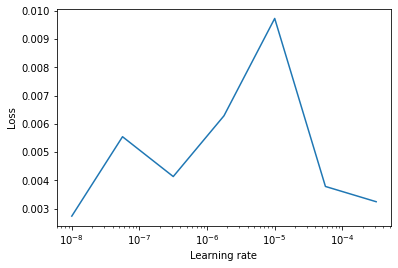

In [13]:
(lrs, losses) = find_lr(transfer_model, torch.nn.CrossEntropyLoss(),optimizer, train_data_loader,device=device)
plt.plot(lrs, losses)

plt.xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()

## Differential Learning Rates

In our training so far, we have applied one learning rate to the entire model. When training a model from scratch, that probably makes sense, but when it comes to transfer learning, we can normally get a little better accuracy if we try something different: training different groups of layers at different rates. 

Earlier in the chapter, we froze all the pretrained layers in our model and trained just our new classifier, but we may want to fine-tune some of the layers of, say, the ResNet model we’re using. Perhaps adding some training to the layers just preceding our classifier will make our model just a little more accurate. 

But as those preceding layers have already been trained on the ImageNet dataset, maybe they need only a little bit of training as compared to our newer layers? PyTorch offers a simple way of making this happen. Let’s modify our optimizer for the ResNet-50 model:

In [14]:
found_lr = 0.0001

In [15]:
optimizer = optim.Adam([
{ 'params': transfer_model.layer4.parameters(), 'lr': found_lr /3},
{ 'params': transfer_model.layer3.parameters(), 'lr': found_lr /9},
{ 'params': transfer_model.fc.parameters(), 'lr': found_lr},    
], lr=found_lr)

In [16]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 3.3333333333333335e-05
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1.1111111111111112e-05
    weight_decay: 0

Parameter Group 2
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)

That sets the learning rate for layer4 (just before our classifier) to a third of the found learning rate and a ninth for layer3. That combination has empirically worked out quite well in my work, but obviously feel free to experiment. 

There’s one more thing, though. As you may remember from the beginning of this chapter, we froze all these pretrained layers. It’s all very well to give them a different learning rate, but as of right now, the model training won’t touch them at all because they don’t accumulate gradients. Let’s change that:

In [17]:
unfreeze_layers = [transfer_model.layer3, transfer_model.layer4]
for layer in unfreeze_layers:
    for param in layer.parameters():
        param.requires_grad = True

Now that the parameters in these layers take gradients once more, the differential learning rates will be applied when you fine-tine the model. Note that you can freeze and unfreeze parts of the model at will and do further fine-tuning on every layer separately if you’d like!

In [18]:
train(transfer_model, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=5, 
      device=device)

 20%|██        | 1/5 [00:07<00:28,  7.01s/it]

Epoch: 0, Training Loss: 0.02, Validation Loss: 0.11, accuracy = 0.96


 40%|████      | 2/5 [00:14<00:21,  7.01s/it]

Epoch: 1, Training Loss: 0.01, Validation Loss: 0.21, accuracy = 0.95


 60%|██████    | 3/5 [00:21<00:14,  7.01s/it]

Epoch: 2, Training Loss: 0.01, Validation Loss: 0.16, accuracy = 0.95


 80%|████████  | 4/5 [00:27<00:06,  7.00s/it]

Epoch: 3, Training Loss: 0.01, Validation Loss: 0.13, accuracy = 0.96


100%|██████████| 5/5 [00:35<00:00,  7.00s/it]

Epoch: 4, Training Loss: 0.02, Validation Loss: 0.23, accuracy = 0.92


## Data Augmentation

torchvision comes complete with a large collection of potential transforms that can be used for data augmentation, plus two ways of constructing new transformations. In this section, we look at the most useful ones that come supplied as well as a couple of custom transformations that you can use in your own applications.

In [19]:
transforms_ = transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225] )
        ])

This forms a transformation pipeline that all images go through as they enter the model for training. But the torchivision.transforms library contains many other transformation functions that can be used to augment training data.

ColorJitter randomly changes the brightness, contrast, saturation, and hue of an image. For brightness, contrast, and saturation, you can supply either a float or a tuple of floats, all nonnegative in the range 0 to 1, and the randomness will either be between 0 and the supplied float or it will use the tuple to generate randomness between the supplied pair of floats. For hue, a float or float tuple between –0.5 and 0.5 is required, and it will generate random hue adjustments between [-hue,hue] or [min, max].

In [20]:
torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)

ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)

If you want to flip your image, these two transforms randomly reflect an image on either the horizontal or vertical axis:

In [21]:
torchvision.transforms.RandomHorizontalFlip(p=0.5)
torchvision.transforms.RandomVerticalFlip(p=0.5)

RandomVerticalFlip(p=0.5)

Either supply a float from 0 to 1 for the probability of the reflection to occur or accept the default of a 50% chance of reflection.

RandomGrayscale is a similar type of transformation, except that it randomly turns the image grayscale, depending on the parameter p (the default is 10%):

In [22]:
torchvision.transforms.RandomGrayscale(p=0.1)

RandomGrayscale(p=0.1)

RandomCrop and RandomResizeCrop, as you might expect, perform random crops on the image of size, which can either be an int for height:

In [23]:
torchvision.transforms.RandomCrop((64, 64), padding=None,
pad_if_needed=False, fill=0, padding_mode='constant')
torchvision.transforms.RandomResizedCrop((64, 64), scale=(0.08, 1.0),
ratio=(0.75, 1.3333333333333333), interpolation=2)

RandomResizedCrop(size=(64, 64), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)

While the RandomResizeCrop will resize the crop to fill the given size, RandomCrop may take a crop close to the edge and into the darkness beyond the image.

RandomResizeCrop is using Bilinear interpolation, but you can also select nearest neighbor or bicubic interpolation by changing the interpolation parameter. See the PIL filters page for further details.

If you’d like to randomly rotate an image, RandomRotation will vary between [-degrees, degrees] if degrees is a single float or int, or (min,max) if it is a tuple:

In [24]:
torchvision.transforms.RandomRotation(90, resample=False,expand=False, center=None)

RandomRotation(degrees=(-90, 90), resample=False, expand=False)

If expand is set to True, this function will expand the output image so that it can include the entire rotation; by default, it’s set to crop to within the input dimensions. You can specify a PIL resampling filter, and optionally provide an (x,y) tuple for the center of rotation; otherwise the transform will rotate about the center of the image.

## Color Spaces and Lambda Transforms

This may seem a little odd to even bring up, but so far all our image work has been in the fairly standard 24-bit RGB color space, where every pixel has an 8-bit red, green, and blue value to indicate the color of that pixel. However, other color spaces are available!

A popular alternative is HSV, which has three 8-bit values for hue, saturation, and value. Some people feel this system more accurately models human vision than the traditional RGB color space. But why does this matter? A mountain in RGB is a mountain in HSV, right?

Well, there’s some evidence from recent deep learning work in colorization that other color spaces can produce slightly higher accuracy than RGB. A mountain may be a mountain, but the tensor that gets formed in each space’s representation will be different, and one space may capture something about your data better than another.

When combined with ensembles, you could easily create a series of models that combines the results of training on RGB, HSV, YUV, and LAB color spaces to wring out a few more percentage points of accuracy from your prediction pipeline.

One slight problem is that PyTorch doesn’t offer a transform that can do this. But it does provide a couple of tools that we can use to randomly change an image from standard RGB into HSV (or another color space). First, if we look in the PIL documentation, we see that we can use Image.convert() to translate a PIL image from one color space to another. 

We could write a custom transform class to carry out this conversion, but PyTorch adds a transforms.Lambda class so that we can easily wrap any function and make it available to the transform pipeline. Here’s our custom function:

In [25]:
def _random_colour_space(x):
    output = x.convert("HSV")
    return output

This is then wrapped in a transforms.Lambda class and can be used in any standard transformation pipeline like we’ve seen before:

In [26]:
colour_transform = transforms.Lambda(lambda x: _random_colour_space(x))

That’s fine if we want to convert every image into HSV, but really we don’t want that. 
We’d like it to randomly change images in each batch, so it’s probable that the image will be presented in different color spaces in different epochs. 

We could update our original function to generate a random number and use that to generate a random probability of changing the image, but instead we’re even lazier and use RandomApply:

In [27]:
random_colour_transform = torchvision.transforms.RandomApply([colour_transform])

By default, RandomApply fills in a parameter p with a value of 0.5, so there’s a 50/50 chance of the transform being applied. Experiment with adding more color spaces and the probability of applying the transformation to see what effect it has on our cat and fish problem.

## Custom Transform Classes

Sometimes a simple lambda isn’t enough; maybe we have some initialization or state that we want to keep track of, for example. In these cases, we can create a custom transform that operates on either PIL image data or a tensor. 

Such a class has to implement two methods: __call__, which the transform pipeline will invoke during the transformation process; and __repr__, which should return a string representation of the transform, along with any state that may be useful for diagnostic purposes.

In the following code, we implement a transform class that adds random Gaussian noise to a tensor. When the class is initialized, we pass in the mean and standard distribution of the noise we require, and during the __call__ method, we sample from this distribution and add it to the incoming tensor:

In [28]:
class Noise():
    """Adds gaussian noise to a tensor.
    
    Example:
        >>> transforms.Compose([
        >>>     transforms.ToTensor(),
        >>>     Noise(0.1, 0.05)),
        >>> ])
    
    """
    def __init__(self, mean, stddev):
        self.mean = mean
        self.stddev = stddev

    def __call__(self, tensor):
        noise = torch.zeros_like(tensor).normal_(self.mean, self.stddev)
        return tensor.add_(noise)
    
    def __repr__(self):
        repr = f"{self.__class__.__name__  }(mean={self.mean},sttdev={self.stddev})"
        return repr

If we add this to a pipeline, we can see the results of the __repr__ method being called:

In [29]:
custom_transform_pipeline = transforms.Compose([random_colour_transform, Noise(0.1, 0.05)])

In [30]:
custom_transform_pipeline

Compose(
    RandomApply(
    p=0.5
    Lambda()
)
    Noise(mean=0.1,sttdev=0.05)
)

Because transforms don’t have any restrictions and just inherit from the base Python object class, you can do anything. Want to completely replace an image at runtime with something from Google image search? Run the image through a completely different neural network and pass that result down the pipeline? And so on.

Aside from transformations, there are a few more ways of squeezing as much performance from a model as possible. Let’s look at more examples.

## Start Small and Get Bigger!

Here’s a tip that seems odd, but obtains real results: start small and get bigger. What I mean is if you’re training on 256 × 256 images, create a few more datasets in which the images have been scaled to 64 × 64 and 128 × 128. Create your model with the 64 × 64 dataset, fine-tune as normal, and then train the exact same model with the 128 × 128 dataset. Not from scratch, but using the parameters that have already been trained. Once it looks like you’ve squeezed the most out of the 128 × 128 data, move on to your target 256 × 256 data. You’ll probably find a percentage point or two improvement in accuracy.

While we don’t know exactly why this works, the working theory is that by training at the lower resolutions, the model learns about the overall structure of the image and can refine that knowledge as the incoming images expand. But that’s just a theory. However, that doesn’t stop it from being a good little trick to have up your sleeve when you need to squeeze every last bit of performance from a model.

If you don’t want to have multiple copies of a dataset hanging around in storage, you can use torchvision transforms to do this on the fly using the Resize function:

The penalty you pay here is that you end up spending more time in training, as PyTorch has to apply the resize every time. If you resized all the images beforehand, you’d likely get a quicker training run, at the expense of filling up your hard drive. But isn’t that trade-off always the way?

The concept of starting small and then getting bigger also applies to architectures. Using a ResNet architecture like ResNet-18 or ResNet-34 to test out approaches to transforms and get a feel for how training is working provides a much tighter feedback loop than if you start out using a ResNet-101 or ResNet-152 model. Start small, build upward, and you can potentially reuse the smaller model runs at prediction time by adding them to an ensemble model.

## Ensembles

What’s better than one model making predictions? Well, how about a bunch of them? Ensembling is a technique that is fairly common in more traditional machine learning methods, and it works rather well in deep learning too. The idea is to obtain a prediction from a series of models, and combine those predictions to produce a final answer. Because different models will have different strengths in different areas, hopefully a combination of all their predictions will produce a more accurate result than one model alone.

There are plenty of approaches to ensembles, and we won’t go into all of them here. Instead, here’s a simple way of getting started with ensembles, one that has eeked out another 1% of accuracy in my experience; simply average the predictions:

In [31]:
models_ensemble = [models.resnet50().to(device), models.resnet50().to(device)]
predictions = [F.softmax(m(torch.rand(1,3,224,244).to(device))) for m in models_ensemble] 
avg_prediction = torch.stack(predictions).mean(0).argmax()

/home/anton/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [32]:
avg_prediction

tensor(421, device='cuda:0')

In [33]:
torch.stack(predictions)

tensor([[[0.0005, 0.0008, 0.0022,  ..., 0.0006, 0.0003, 0.0020]],

        [[0.0008, 0.0007, 0.0006,  ..., 0.0010, 0.0005, 0.0004]]],
       device='cuda:0', grad_fn=<StackBackward>)

The stack method concatenates the array of tensors together, so if we were working on the cat/fish problem and had our models in our ensemble, we’d end up with a 4 × 2 tensor constructed from the four 1 × 2 tensors. And mean does what you’d expect, taking the average, although we have to pass in a dimension of 0 to ensure that it takes an average across the first dimension instead of simply adding up all the tensor elements and producing a scalar output. Finally, argmax picks out the tensor index with the highest element, as you’ve seen before.

It’s easy to imagine more complex approaches. Perhaps weights could be added to each individual model’s prediction, and those weights adjusted if a model gets an answer right or wrong. What models should you use? I’ve found that a combination of ResNets (e.g., 34, 50, 101) work quite well, and there’s nothing to stop you from saving your model regularly and using different snapshots of the model across time in your ensemble!